<a href="https://colab.research.google.com/github/Chiriviki/congreso/blob/master/4.-%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualización final

Elaboración de la visualización final

## Config

In [1]:
!pip install altair==5.0.0
!pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.4/477.4 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import cv2

from wordcloud import WordCloud
from PIL import Image as im

import matplotlib.pyplot as plt

import altair as alt

alt.data_transformers.disable_max_rows()

alt.__version__

'5.0.0'

## Carga de datos

In [3]:
!wget https://github.com/Chiriviki/congreso/raw/master/dataset.zip
!unzip dataset.zip -d "dataset"

--2023-05-28 11:15:23--  https://github.com/Chiriviki/congreso/raw/master/dataset.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Chiriviki/congreso/master/dataset.zip [following]
--2023-05-28 11:15:23--  https://raw.githubusercontent.com/Chiriviki/congreso/master/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57078988 (54M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  54.43M   152MB/s    in 0.4s    

2023-05-28 11:15:24 (152 MB/s) - ‘dataset.zip’ saved [57078988/57078988]

Archive:  dataset.zip
  inflating: dataset/Anexo_Diputados_

In [4]:
data_grupo = pd.read_csv("dataset/final_grupo.csv", index_col=0)
data_fecha = pd.read_csv("dataset/final_fecha.csv", index_col=0)

In [5]:
data_grupo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, aplausos to sucede
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mi_grupo  300 non-null    float64
 1   ERC       300 non-null    float64
 2   PNV       300 non-null    float64
 3   PP        300 non-null    float64
 4   PSOE      300 non-null    float64
 5   UP        300 non-null    float64
 6   Vox       300 non-null    float64
dtypes: float64(7)
memory usage: 18.8+ KB


## Gráficas de grupos

In [6]:
# Colores de cada partido
color_domain = ['ERC', 'PNV', 'PP', 'PSOE', 'UP', 'Vox']
color_range = ['#fbc259', '#426938', '#1e4b8f', '#e30713', '#693065', '#5ac036']

In [7]:
source_grupo = data_grupo.reset_index(names=["term"]).sort_values("mi_grupo", ascending=False).iloc[:20, :]

In [8]:
base_grupo = alt.Chart(source_grupo).encode(
    row=alt.Row(
        "term:N",
        sort=alt.EncodingSortField(field="mi_grupo", op="mean", order="descending"),
        title="",
        spacing=0,
        header=alt.Header(
            labelAngle=0,
            labelAlign="left",
            labelOrient="left"
                )
    )
)

In [9]:
chart_mi_grupo = base_grupo.encode(
    alt.X('mean(mi_grupo):Q',
         title='Relevancia (Información mutua)'),      
).mark_bar(
    color="#d2bd5a",
    opacity=0.6,
    height=20,
).properties(height=20, width=100)

chart_mi_grupo

alt.Chart(...)

In [10]:
selection = alt.selection_point(fields=['_grupo'], bind='legend')


chart_tfidf_grupo = base_grupo.transform_fold(
    ["PSOE", "PP", "Vox", "UP", "ERC", "PNV"],
    ["_grupo", "tfidf"]    
).encode(
    row=alt.Row(
        "term:N",
        sort=alt.EncodingSortField(field="mi_grupo", op="mean", order="descending"),
        title="",
        spacing=0,
        header=None
    ),
    
    x=alt.X('tfidf:Q', title="Frecuencia (TF-IDF) x Partido").scale(type="sqrt"),
    color=alt.Color("_grupo:N",title="Partido", scale=alt.Scale(domain=color_domain,range=color_range)),
    opacity=alt.condition(
        selection,
        alt.value(1),
        alt.value(0.5)
    )
).mark_circle(size=100).add_params(
    selection
).properties(height=20, width=300)

chart_grupo = alt.hconcat(
    chart_mi_grupo, chart_tfidf_grupo,
    spacing=0,
    title=alt.TitleParams(
        ["Términos más representativos entre partidos políticos"],
        align="center",
        anchor="middle"
    )
)
chart_grupo

alt.HConcatChart(...)

## Gráficas de fechas

In [11]:
source_fecha = data_fecha.reset_index(
    names=["term"]
).sort_values(
    "mi_fecha",
    ascending=False
).iloc[:20, :].melt(
    id_vars=["term", "mi_fecha"],
    var_name="_fecha",
    value_name="tfidf"
)

In [12]:
base_fecha = alt.Chart(source_fecha).encode(
    row=alt.Row(
        "term:N",
        sort=alt.EncodingSortField(field="mi_fecha", op="mean", order="descending"),
        title="",
        spacing=0,
        header=alt.Header(
            labelAngle=0,
            labelAlign="left",
            labelOrient="left"
                )
    )
)

In [13]:
chart_mi_fecha = base_fecha.encode(
    alt.X('mean(mi_fecha):Q',
         title='Relevancia (Información mutua)'),      
).mark_bar(
    color="#0d347f",
    opacity=0.6,
    height=20
).properties(height=20, width=100)

chart_mi_fecha

alt.Chart(...)

In [14]:
chart_tfidf_fecha = base_fecha.transform_aggregate(
    mean_tf='mean(tfidf)',
    groupby=["term", "_fecha"]

).encode(
    row=alt.Row(
        "term:N",
        sort=alt.EncodingSortField(field="mi_fecha", op="mean", order="descending"),
        title="",
        spacing=0,
        header=None
    ),
    y=alt.Y('mean_tf:Q', axis=None),
    x=alt.X('yearmonth(_fecha):T', title="Frecuencia (TF-IDF) x Fecha (mes-año)")
).mark_area(
    color="#0d347f",
    opacity=0.5,
    height=20
).properties(height=20, width=300).resolve_scale(y="independent")

chart_fecha = alt.hconcat(
    chart_mi_fecha, chart_tfidf_fecha,
    spacing=0,
    title=alt.TitleParams(
        ["Términos más representativos en momentos de la legislatura"],
        align="center",
        anchor="middle"
    )
).resolve_scale(color="independent")

chart_fecha

alt.HConcatChart(...)

In [15]:
final = alt.hconcat(chart_fecha,chart_grupo)
final

alt.HConcatChart(...)

## Wordcloud

Normalizamos los valores de frecuencias entre partidos

In [16]:
tf_partidos = data_grupo.iloc[:, 1:]

Se crea el diagrama que se va a usar como máscara. Se utiliza un gráfico semicircular con los valores del número de intervenciones en el dataset.

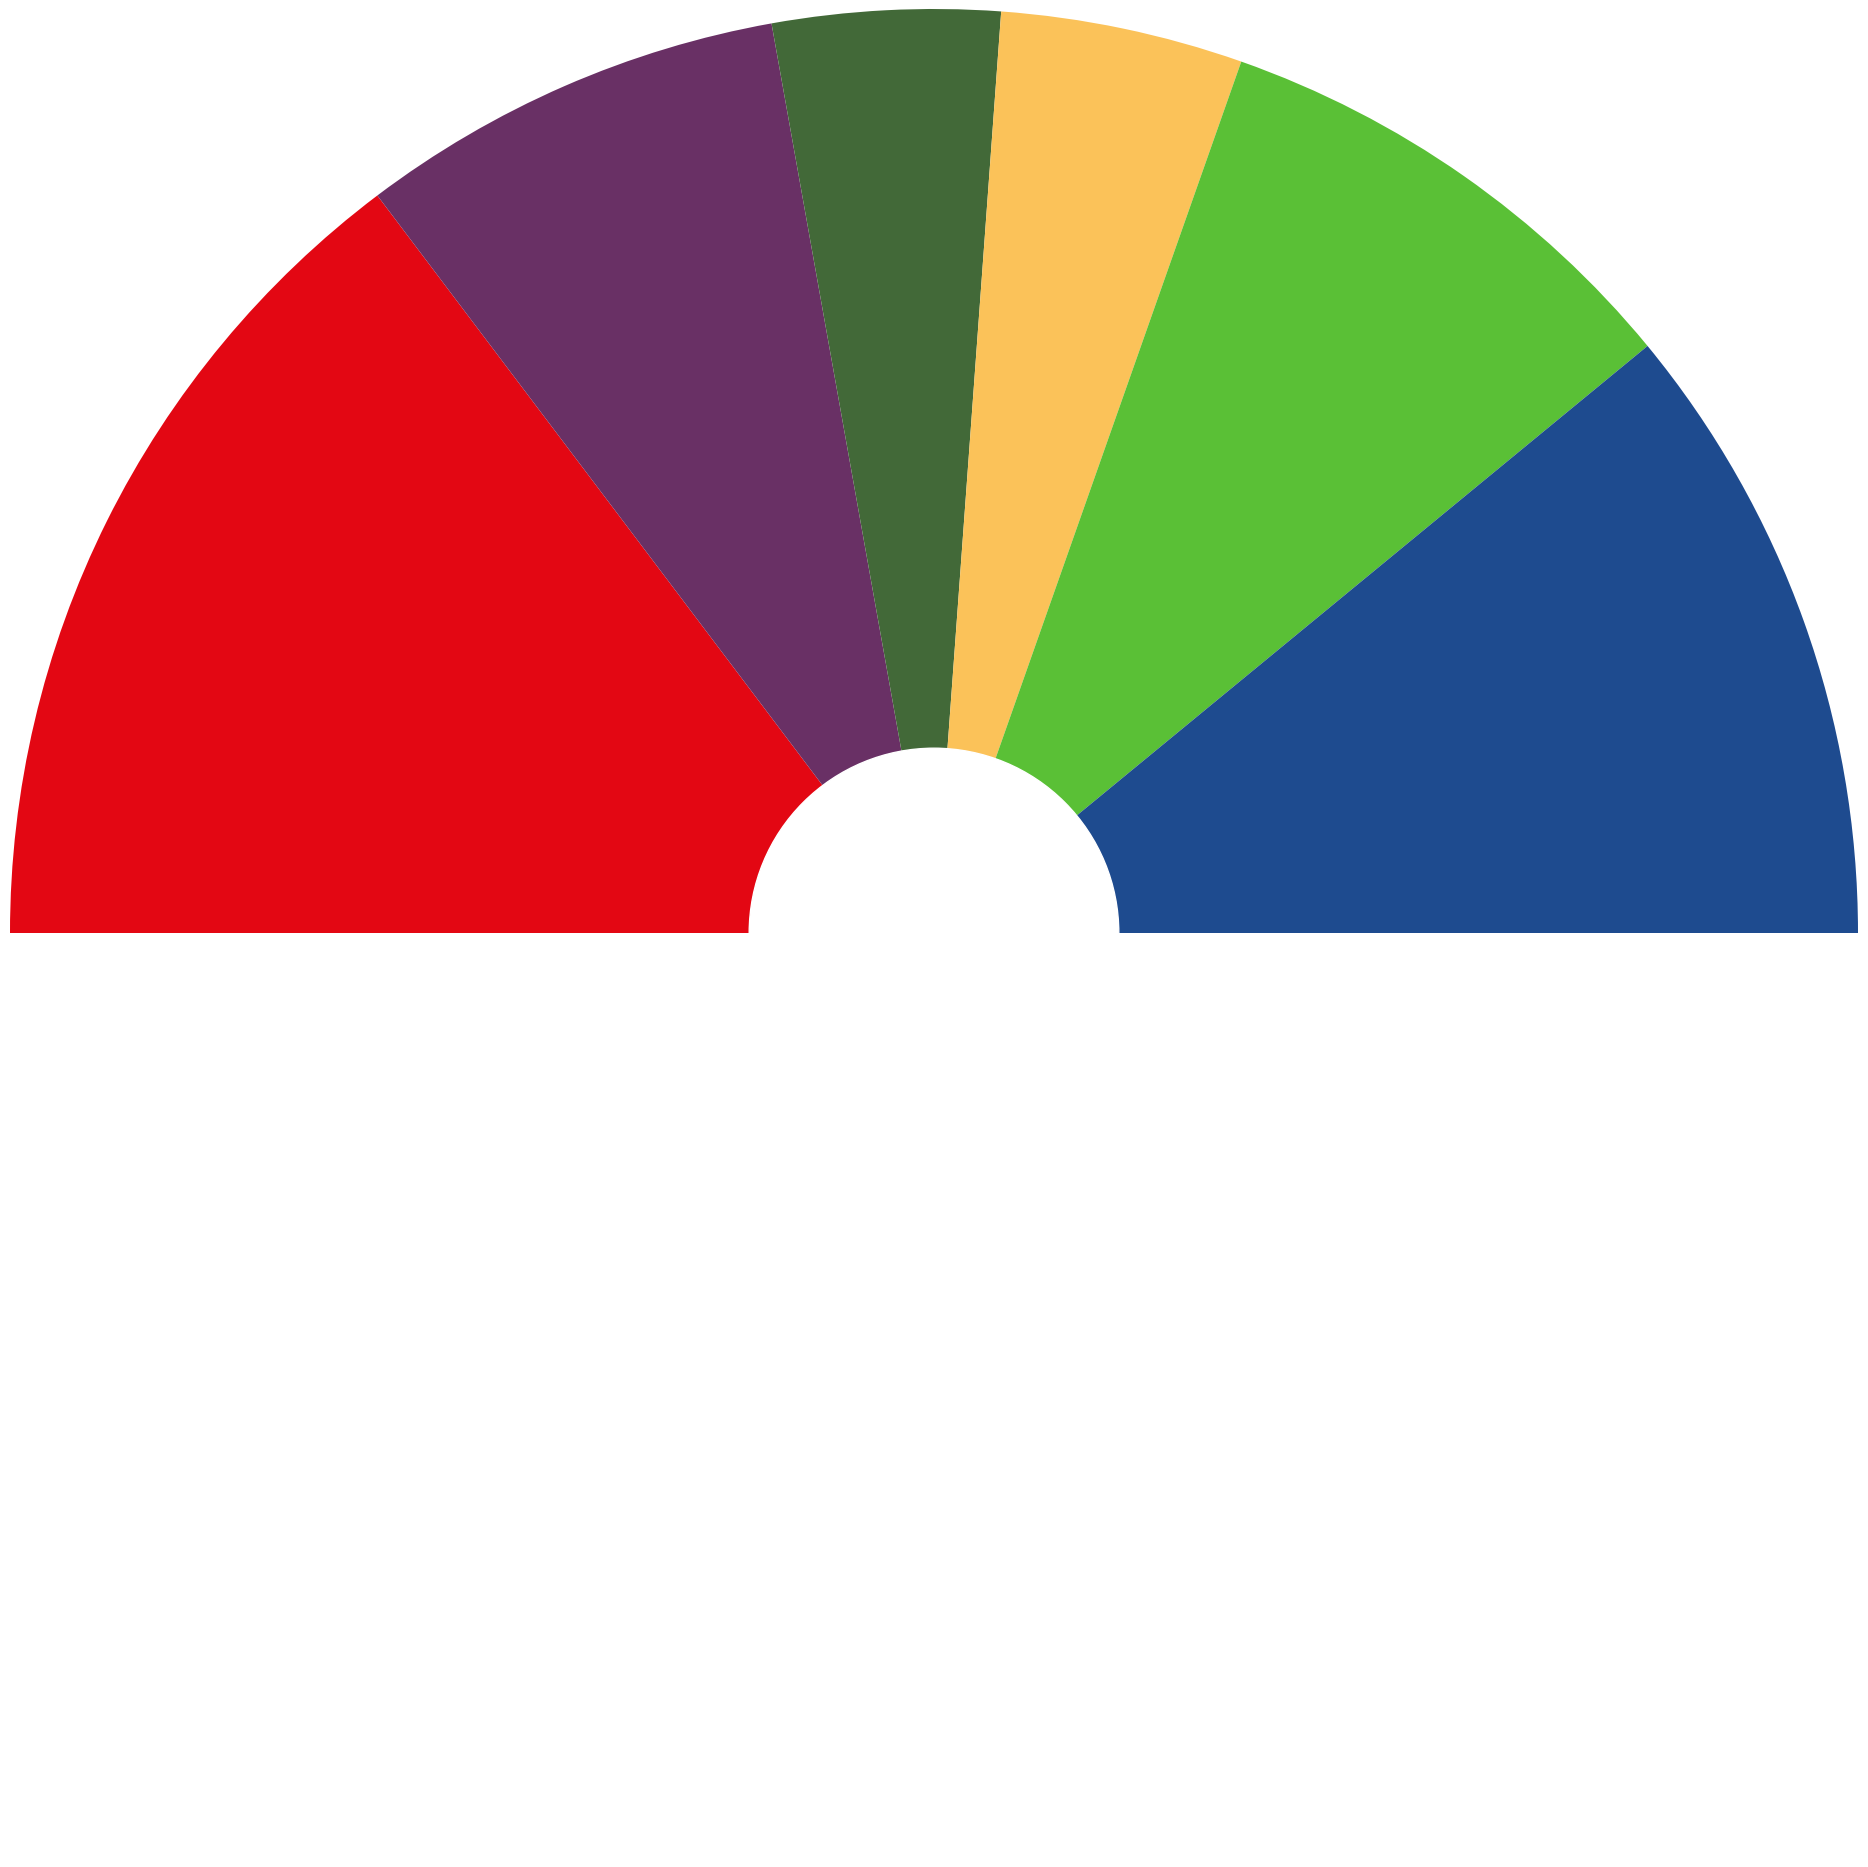

In [17]:
values = [3555, 1807,  960,1024, 2090, 2648]
values.append(sum(values))

color_domain = ["PSOE", "UP", "PNV", "ERC", "Vox", "PP"]
color_range = ['#e30713', '#693065', '#426938', '#fbc259', '#5ac036', '#1e4b8f']
colors_dict = dict(zip(
    color_domain,
    [color for color in color_range]
))

colors = [colors_dict[grupo] for grupo in color_domain]
colors.append("white")


def hex_to_rgb(color_hex):
    h = color_hex.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

colors_rgb = dict(zip(
    color_domain,
    [hex_to_rgb(color) for color in color_range]
))


fig = plt.figure(figsize=(20,20),dpi=100)
ax = fig.add_subplot(1,1,1)
ax.pie(
    values,
    colors=colors,
    counterclock=False,
    startangle=180,
    radius=1.5
)
ax.add_artist(plt.Circle((0, 0), 0.3, color='white'))
fig.canvas.draw()
image = im.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())

image = image.crop((0, 0, image.size[0], image.size[1]/2))

Se crea el wordcloud extrayendo la máscara por colores. El tamaño de cada palabra está definido por la frecuencia

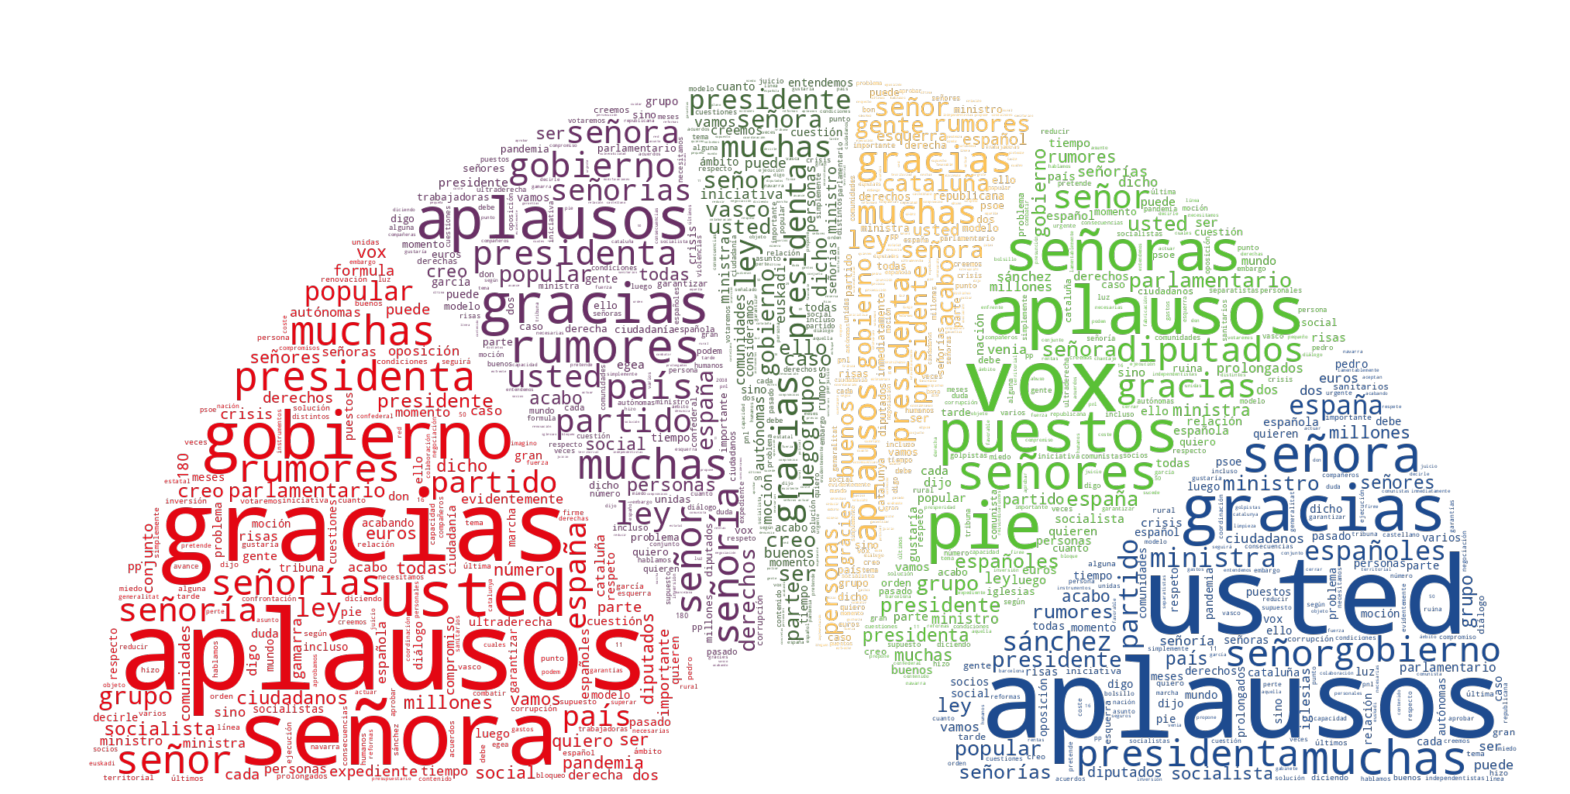

In [18]:
def extract_mask(color):
    img = np.array(image)

    lower = np.array(color)
    upper = np.array(color)

    mask = cv2.inRange(img, lower, upper)
    
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(lambda x: 255 if x==0 else 0, mask[i]))

    return transformed_mask


def generate_cloud(freqs, color):
    wordcloud = WordCloud(
        width=2000,
        height=2000,
        max_words=200,
        mode="RGBA",
        background_color=None,
        color_func=lambda *args, **kwargs: color,
        mask=extract_mask(color)
    )
    wordcloud.generate_from_frequencies(frequencies=freqs)
    
    return wordcloud

def generate_cloud_partido(partido):
    return generate_cloud(
        tf_partidos.loc[:, partido].to_dict(),
        colors_rgb[partido]
    )


plt.figure(figsize=(20,20), dpi=100)

for grupo in color_domain:
    cloud =generate_cloud_partido(grupo)

    plt.imshow(cloud, interpolation="bilinear")

plt.axis("off")

plt.savefig("wordcloud.png", dpi=300, bbox_inches="tight")

## Título

Para continuar, es necesario subir la imagen a internet. En este caso se ha subido a img.bb ya que no he logrado que funcione con la imagen en Github

In [29]:
url = "https://i.ibb.co/XxN75Jm/wordcloud.png"
# url = "https://raw.githubusercontent.com/Chiriviki/congreso/blob/master/wordcloud.png"
data = pd.DataFrame({"imagen":[url]})

In [30]:
nube_chart = alt.Chart(data).mark_image(
    width=2000,
    height=500,
    
).encode(
    x=alt.value(500), x2=alt.value(1000), 
    y=alt.value(0), y2=alt.value(200), 
    url='imagen:N',
    
).properties(
    title=alt.TitleParams(
        "La XIV legislatura en 40 palabras", 
        color="gray",
        fontSize=30,
        dy=100,
        dx=260
    
    )
)

sub_text = alt.Chart({'values':[{}]}).mark_text(
    align="left",
    color="grey",
    size=8
).encode(
    x=alt.value(950),  # pixels from left
    y=alt.value(175),  # pixels from top
    text=alt.value(["Nube de palabras", "generada automáticamente", "de los textos extraídos."]))


nube_chart = alt.layer(nube_chart, sub_text)
nube_chart

alt.LayerChart(...)

In [31]:
url2 = "https://i.ibb.co/sqgsrJ0/image.png"
data2 = pd.DataFrame({"imagen":[url2]})

logo_chart = alt.Chart(data2).mark_image(
    width=2000,
    height=500,
    
).encode(
    x=alt.value(300), x2=alt.value(500), 
    y=alt.value(100), y2=alt.value(200), 
    url='imagen:N',
    
).properties(
    title=alt.TitleParams(
        "La XIV legislatura en 40 palabras", 
        color="gray",
        fontSize=30,
        dy=100,
        dx=260
    
    )
)

logo_chart

alt.Chart(...)

In [32]:
title = alt.layer(logo_chart,nube_chart)
title

alt.LayerChart(...)

## Visualización final

In [33]:
alt.vconcat(title, final).configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    orient="none",
    legendX=1000,
    legendY=240
)

alt.VConcatChart(...)